In [129]:
from matplotlib import pyplot as plt
from matplotlib.patches import ConnectionPatch
import numpy as np

from collections import Counter

import sklearn.datasets
import sklearn.preprocessing
import sklearn.metrics
from sklearn.model_selection import train_test_split
import sklearn.cluster

# Наши разработки из 3-ей работы))
from nn import Nums
from nn import NN, Layer
from nn.optimizers import AdamOptimizer

from tqdm import tqdm

type Nums = np.ndarray[np.number]

np.set_printoptions(formatter={"float": lambda x: "{0:0.3f}".format(x)})

Не стал нормализовывать в гиперсферу

In [130]:
data_object = sklearn.datasets.load_iris(as_frame=True)
data = data_object.frame
target_names = data_object.target_names

scaler = sklearn.preprocessing.MinMaxScaler()
X = scaler.fit_transform(data.iloc[:, :4])

encoder = sklearn.preprocessing.OneHotEncoder()
Y = encoder.fit_transform(data["target"].values[:, None]).toarray()

In [131]:
train_x, test_x, train_y, test_y = train_test_split(
    X, Y, train_size=0.7, stratify=data["target"]
)

Функция для просмотра состояния карты

In [132]:
def plot_centroids(centroids: Nums, coords2d: Nums):
    fig, (axes) = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))
    axes[0, 0].scatter(X[:, 0], X[:, 1], c=data["target"])
    axes[0, 0].set_xlabel("sepal length (cm)")
    axes[0, 0].set_ylabel("sepal width (cm)")
    axes[0, 0].scatter(centroids[:, [0]], centroids[:, [1]], marker="o", c="red")

    axes[0, 1].scatter(X[:, 0], X[:, 2], c=data["target"])
    axes[0, 1].set_xlabel("sepal length (cm)")
    axes[0, 1].set_ylabel("petal length (cm)")
    axes[0, 1].scatter(centroids[:, [0]], centroids[:, [2]], marker="o", c="red")

    axes[0, 2].scatter(X[:, 0], X[:, 3], c=data["target"])
    axes[0, 2].set_xlabel("sepal length (cm)")
    axes[0, 2].set_ylabel("petal width (cm)")
    axes[0, 2].scatter(centroids[:, [0]], centroids[:, [3]], marker="o", c="red")

    axes[1, 0].scatter(X[:, 1], X[:, 2], c=data["target"])
    axes[1, 0].set_xlabel("sepal width (cm)")
    axes[1, 0].set_ylabel("petal length (cm)")
    axes[1, 0].scatter(centroids[:, [1]], centroids[:, [2]], marker="o", c="red")

    axes[1, 1].scatter(X[:, 1], X[:, 3], c=data["target"])
    axes[1, 1].set_xlabel("sepal width (cm)")
    axes[1, 1].set_ylabel("petal width (cm)")
    axes[1, 1].scatter(centroids[:, [1]], centroids[:, [3]], marker="o", c="red")

    axes[1, 2].scatter(X[:, 2], X[:, 3], c=data["target"])
    axes[1, 2].set_xlabel("petal length (cm)")
    axes[1, 2].set_ylabel("petal width (cm)")
    axes[1, 2].scatter(centroids[:, [2]], centroids[:, [3]], marker="o", c="red")

    fig.suptitle("Iris dataset", fontsize=16)

    to_plot_mapping = {
        (0, 1): (0, 0),
        (0, 2): (0, 1),
        (0, 3): (0, 2),
        (1, 2): (1, 0),
        (1, 3): (1, 1),
        (2, 3): (1, 2),
    }
    
    rows, cols, _ = coords2d.shape

    for dim_x in range(4):
        for dim_y in range(dim_x + 1, 4):
            for x in range(rows):
                for y in range(cols):
                    idx = x * cols + y
                    ax = axes[to_plot_mapping[(dim_x, dim_y)]]
                    neighboring_idx = (x + 1) * cols + y
                    if neighboring_idx < len(centroids):
                        con = ConnectionPatch(centroids[idx][[dim_x, dim_y]], centroids[neighboring_idx][[dim_x, dim_y]], "data", "data", axesA=ax, axesB=ax)
                        fig.add_artist(con)
                        
                    neighboring_idx = (x + 1) * cols + (y + 1)
                    if neighboring_idx < len(centroids):
                        con = ConnectionPatch(centroids[idx][[dim_x, dim_y]], centroids[neighboring_idx][[dim_x, dim_y]], "data", "data", axesA=ax, axesB=ax)
                        fig.add_artist(con)
        
    return fig, axes

Класс Топологии карты и Класс модели самоорганизующейся карты Кохонена

In [133]:
class Map2D:
    def __init__(self, x, y) -> None:
        self.x = x
        self.y = y
        self.coords = self.calc_coords()

    def calc_coords(self):
        coords = np.array([(i, j) for i in range(self.x) for j in range(self.y)])
        return coords
    
    def norm(self, xs: Nums, y: Nums) -> Nums:
        # Норма расстояния между двумя векторами
        return np.sqrt(np.sum(np.square(xs - y), axis=1))
    
    def node_count(self):
        return self.x * self.y
    
    def g(self, idx: int, sigma: float) -> Nums:
        """
        Функция близости в пространстве карты между нейроном под индексом idx
        и всеми остальными, включая сам нейрон
        """
        coords_from = self.coords[idx]
        
        return np.exp(-np.sum(np.square(coords_from - self.coords) / (2 * sigma ** 2), axis=1))

class KohonenMap:
    def __init__(self, inner_dim: int, map: Map2D) -> None:
        self.neuron_count = map.node_count()
        self.inner_dim = inner_dim
        self.map = map
        self.weights = np.ones((self.neuron_count, inner_dim)) / np.sqrt(inner_dim)
    
    def norm(self, x: Nums, ys: Nums):
        # Евклидово расстояние
        return np.sqrt(np.sum(np.square(x - ys), axis=1))
    
    def fit(self, xs: Nums, alpha: float, sigma: float, learning_rate: float):
        for x in xs:
            x = alpha * x + (1 / np.sqrt(self.inner_dim)) * (1 - alpha)
            
            distances = self.norm(x, self.weights)

            best_index = np.argmin(distances)
            gs = self.map.g(best_index, sigma)
            impacts = (x - self.weights) * gs[:, None]

            self.weights = self.weights + learning_rate * (impacts)
    
    def predict_distances(self, xs):
        # Расстояние евклидово, чем меньше - тем лучше
        return np.apply_along_axis(self.norm, 1, xs, self.weights)

    def predict(self, xs):
        preds = []
        for x in xs:
            distances = self.norm(x, self.weights)
            best_index = np.argmin(distances)
            preds.append(best_index)
        return np.array(preds)

Обучаем, начиная с большого значения сигмы, чтобы карта "притянулась в пространство, где больше всего точек", также и learning_rate изначально большой

Здесь применяется приведение весов к форме $1/\sqrt{n}$

Входные вектора преобразуются по формуле $\alpha * x + (1 / \sqrt{n}) * (1 - \alpha)$, где n - количество признаков во входном пространстве

alpha постепенно увеличиваем.

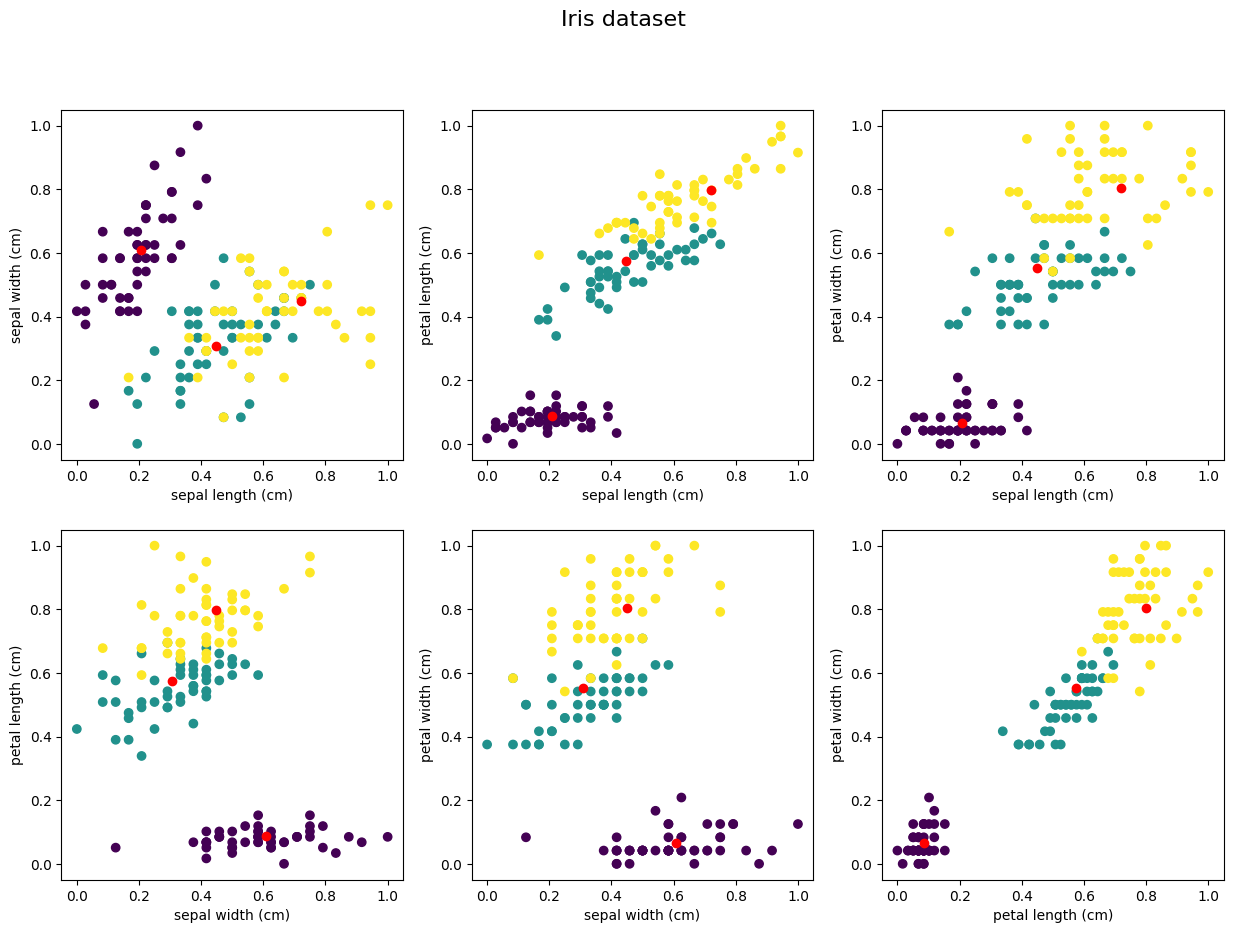

In [134]:
def train(
    model: KohonenMap,
    x: Nums,
    sigma: float,
    learning_rate: float,
    num_epoches: int,
):
    sigma_start = sigma
    learning_rate_start = learning_rate

    learning_rate = learning_rate_start
    sigma = sigma_start

    indices = np.arange(len(x))
    np.random.shuffle(indices)

    for i in range(num_epoches):
        alpha = i / num_epoches
        model.fit(x[indices], alpha, sigma, learning_rate)

        sigma = sigma_start * (1 - i / num_epoches)
        learning_rate = learning_rate_start * (1 - i / num_epoches)


kmap = KohonenMap(4, Map2D(1, 3))
train(kmap, train_x, 1, 0.1, 1000)
plot_centroids(kmap.weights, kmap.map.coords.reshape(kmap.map.x, kmap.map.y, 2));

In [135]:
predicted = kmap.predict(test_x)
y_true = np.argmax(test_y, axis=1)
predicted

array([1, 2, 1, 1, 1, 1, 1, 1, 0, 1, 2, 1, 0, 0, 1, 1, 1, 0, 1, 2, 0, 1,
       0, 0, 2, 1, 0, 1, 0, 2, 0, 1, 2, 0, 1, 2, 2, 2, 0, 2, 0, 0, 1, 2,
       0])

Для каждого кластера надём наиболее частый вариант признака для отображения, возьмём такой признак, как класс ириса

In [136]:
def count_labels(num_clusters, predicted, labels):
    mapping = {cluster: [] for cluster in range(num_clusters)}

    for cluster, label in zip(predicted, labels):
        mapping[cluster].append(label)

    for cluster in mapping:
        most_common = Counter(mapping[cluster]).most_common(1)
        if len(most_common) == 0:
            most_common = 0
        else:
            most_common = most_common[0][0]
            
        mapping[cluster] = most_common

    cluster_labels = list(mapping.values())
    return cluster_labels

cluster_classes = count_labels(kmap.neuron_count, predicted, [int(x) for x in y_true])
cluster_classes

[0, 1, 2]

Сделаем простейшую классификацию на основе моды класса для каждого кластера

In [137]:
sklearn.metrics.accuracy_score(y_true, [cluster_classes[cluster] for cluster in predicted])

0.8666666666666667

[255, 0, 0] setosa
[0, 255, 0] versicolor
[0, 0, 255] virginica
[0, 0, 0] none


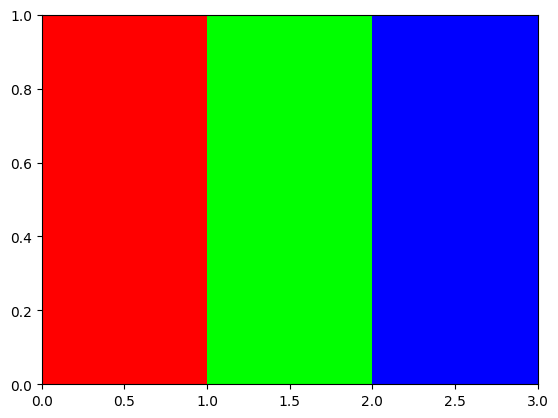

In [138]:
def plot_map2d(coords, labels, target_names, color_mapping):
    rows, cols, _ = coords.shape

    data_to_plot = [color_mapping[l] for l in labels]
    data_to_plot = np.array(data_to_plot).reshape((rows, cols, 3)).astype(np.uint8)
    fig, ax = plt.subplots()

    for color in list(color_mapping.keys()):
        print(color_mapping[color], target_names[color])

    ax.pcolormesh(data_to_plot);

plot_map2d(kmap.map.coords.reshape((kmap.map.x, kmap.map.y, 2)), cluster_classes, [*target_names, "none"], {
        0: [255, 0, 0],
        1: [0, 255, 0],
        2: [0, 0, 255],
        3: [0, 0, 0],
    })

Изучим весь датасет, создав большую карту

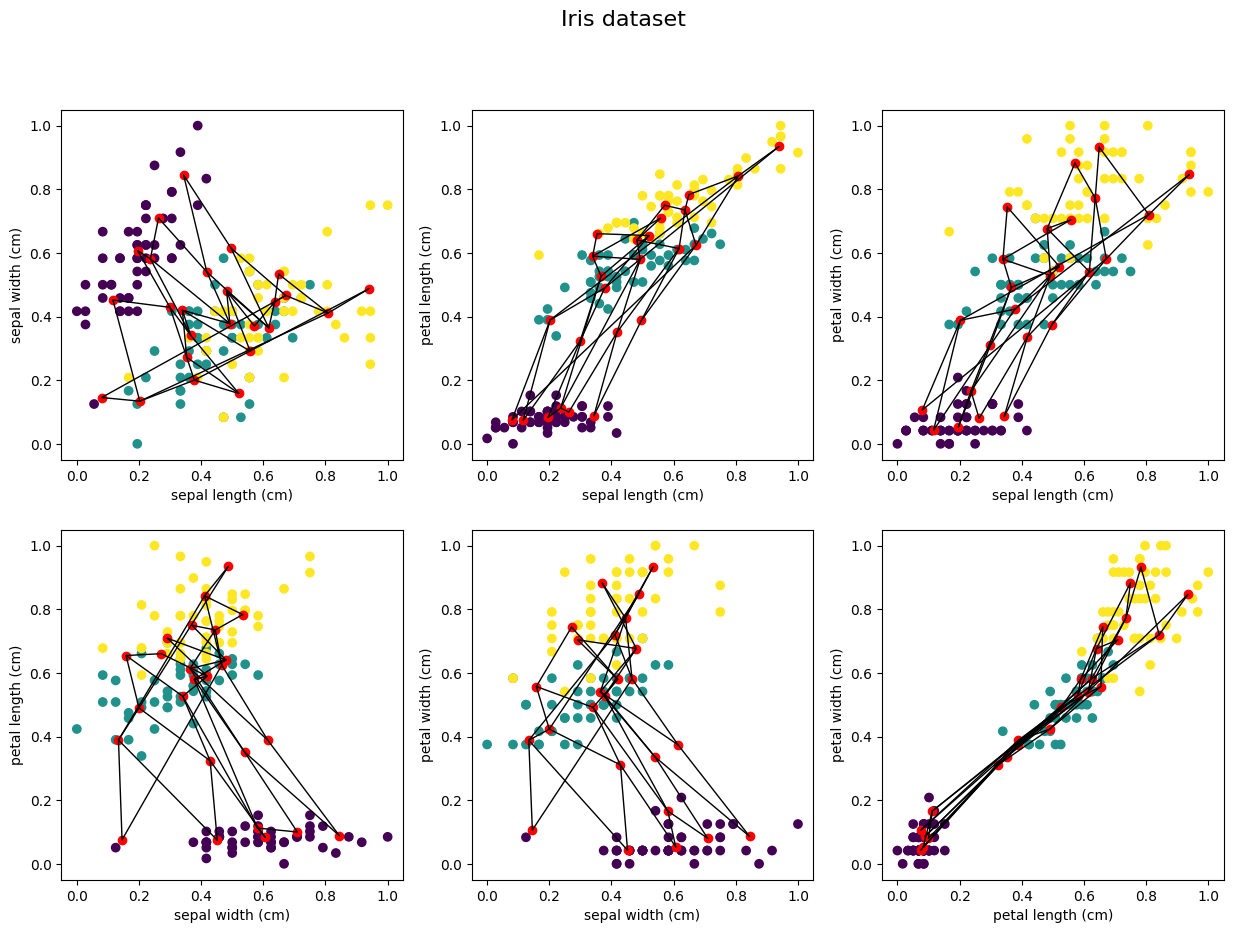

In [139]:
analysys_kmap = KohonenMap(4, Map2D(5, 5))
train(analysys_kmap, X, 1, 0.5, 1000)
plot_centroids(analysys_kmap.weights, analysys_kmap.map.coords.reshape(analysys_kmap.map.x, analysys_kmap.map.y, 2));

In [140]:
cluster_classes = count_labels(analysys_kmap.neuron_count, analysys_kmap.predict(X), [int(x) for x in np.argmax(Y, axis=1)])
cluster_classes

[2, 2, 2, 2, 2, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [141]:
sklearn.metrics.accuracy_score(np.argmax(Y, axis=1), [cluster_classes[cluster] for cluster in analysys_kmap.predict(X)])

0.9533333333333334

[255, 0, 0] setosa
[0, 255, 0] versicolor
[0, 0, 255] virginica
[0, 0, 0] none


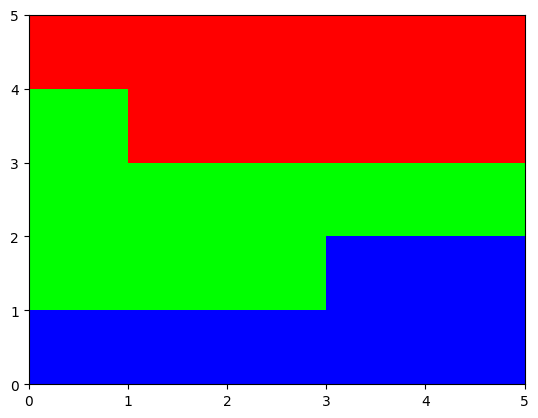

In [142]:
plot_map2d(analysys_kmap.map.coords.reshape((analysys_kmap.map.x, analysys_kmap.map.y, 2)), cluster_classes, [*target_names, "none"], {
        0: [255, 0, 0],
        1: [0, 255, 0],
        2: [0, 0, 255],
        3: [0, 0, 0],
    })

Возьмём предсказания карты с 3-мя кластерами в виде расстояний до каждого кластера (выходы нейронов) и обучим линейный слой предсказывать классы ирисов

In [143]:
kmap_train_output = kmap.predict_distances(train_x)
y_true = np.argmax(train_y, axis=1)
kmap_train_output

array([[1.034, 0.313, 0.154],
       [0.883, 0.320, 0.653],
       [0.930, 0.215, 0.280],
       [0.158, 0.777, 1.183],
       [1.256, 0.583, 0.276],
       [0.883, 0.172, 0.332],
       [0.885, 0.219, 0.524],
       [0.908, 0.362, 0.320],
       [1.368, 0.671, 0.251],
       [0.297, 0.836, 1.266],
       [0.038, 0.819, 1.182],
       [0.124, 0.831, 1.165],
       [0.710, 0.133, 0.580],
       [0.936, 0.225, 0.312],
       [1.048, 0.266, 0.321],
       [0.991, 0.233, 0.362],
       [1.364, 0.821, 0.427],
       [0.197, 0.811, 1.225],
       [1.035, 0.367, 0.160],
       [0.914, 0.166, 0.317],
       [0.117, 0.797, 1.135],
       [0.219, 0.844, 1.145],
       [1.145, 0.453, 0.060],
       [1.149, 0.432, 0.062],
       [1.034, 0.284, 0.428],
       [0.126, 0.680, 1.062],
       [1.356, 0.735, 0.311],
       [0.657, 0.160, 0.545],
       [0.702, 0.215, 0.641],
       [0.762, 0.462, 0.897],
       [0.950, 0.241, 0.512],
       [0.695, 0.109, 0.524],
       [0.164, 0.924, 1.294],
       [0.

In [144]:
network = NN(
    [
        Layer(3, 3, (lambda x: x, lambda x: np.ones_like(x))),
    ],
    loss_function=sklearn.metrics.root_mean_squared_error,
)
loss_history = []

In [145]:
def train_nn(
    network: NN,
    x: Nums,
    y: Nums,
    num_epoches: int,
    learning_rate: float,
    batch_size: int,
    loss_history: list
):
    bar = tqdm(range(1, num_epoches + 1), total=num_epoches)
    xy_indices = np.arange(len(x))
    for epoch in bar:
        network.predicted.clear()
        # В каждой эпохе изменим порядок обучающего датасета
        np.random.shuffle(xy_indices)
        epoch_x = x[xy_indices]
        epoch_y = y[xy_indices]
        network.train(
            epoch_x,
            epoch_y,
            lambda: AdamOptimizer(0.9, 0.999),
            learning_rate=learning_rate,
            batch_size=batch_size,
        )

        loss = network.pop_loss(np.min)
        loss_history.append(loss)

        bar.set_description(
            f"epoch: {epoch}, loss: {loss:.10f}"
        )
        network.losses.clear()
    return loss_history


loss_history = train_nn(network, kmap_train_output, train_y, 100, 0.004, 5, loss_history)

epoch: 100, loss: 0.3208706987: 100%|██████████| 100/100 [00:05<00:00, 19.72it/s]


              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        15
  versicolor       0.74      0.93      0.82        15
   virginica       0.91      0.67      0.77        15

    accuracy                           0.87        45
   macro avg       0.88      0.87      0.86        45
weighted avg       0.88      0.87      0.86        45



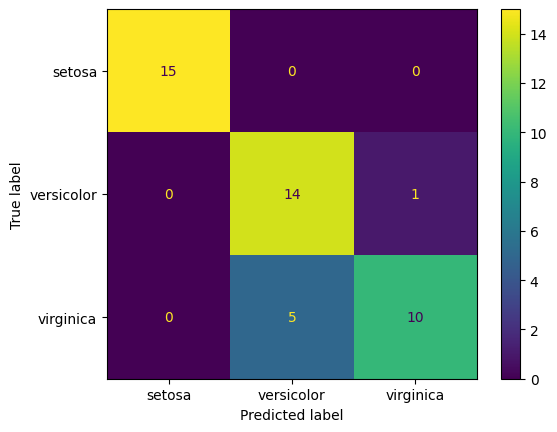

In [146]:
kmap_test_output = kmap.predict_distances(test_x)

y_pred = network.forward(kmap_test_output)
y_true = np.argmax(test_y, axis=1)

y_pred_classes = [target_names[x] for x in np.argmax(y_pred, axis=1)]
y_true_classes = [target_names[x] for x in np.argmax(test_y, axis=1)]

print(sklearn.metrics.classification_report(y_true_classes, y_pred_classes))
sklearn.metrics.ConfusionMatrixDisplay.from_predictions(y_true_classes, y_pred_classes)

Ура!